# NaiveBaise Classifier On Amazon Mobile Reviews

**Importing Required packages**

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer

**Reading the data file into a DATAFRAME and checking the shape **

In [2]:

data=pd.read_csv('35.1AmazonMobileDataUncleaned.csv')  ##, encoding='ISO-8859-1'
print(data.shape)

(71922, 2)


In [3]:
#data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 3'], inplace=True)

**Changing settings of data view**

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', 20000)

In [5]:
#data.iloc[3245:3249,0:2]

In [6]:
data.columns

Index(['uncleanedreview', 'decision'], dtype='object')

In [7]:
#data.drop(columns=['Unnamed: 4'], inplace=True)

**Data Preprocessing**

In [8]:
def datapreprocess(sen):
    
    sen = re.sub(r"didn't", "did not", sen)
    sen = re.sub(r"don't", "do not", sen)
    sen = re.sub(r"won't", "will not", sen)
    sen = re.sub(r"can't", "can not", sen)
    sen = re.sub(r"wasn't", "do not", sen)
    sen = re.sub(r"\'ve", " have", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"\'ll", " will", sen)
    sen = re.sub(r"\'re", " are", sen)
    sen = re.sub(r"\'s", " is", sen)
    sen = re.sub(r"\'d", " would", sen)
    sen = re.sub(r"\'t", " not", sen)
    sen = re.sub(r"\'m", " am", sen)
    sen = re.sub(r"n\'t", " not", sen)
    
    p = set(string.punctuation) # p take all the punctuations, punctuations displayed below
    sen=sen.lower() # convert text to lower case
    words=sen.split() # split the text into words
    ctext=[]
    for i in range(10): #adding numbers from 0 - 9 to p 
        p.add(str(i))
    for i in words:
        t=''.join([x for x in i.encode("ascii","ignore").decode("ascii") if x not in p]) # ignoring non ascii charecters and numbers
        ctext.append(t)
    return " ".join([i for i in ctext]) # joining the cleaned words to text


# Removing stop words

In [9]:
stop=set(stopwords.words('english'))
#print(stop)
stop.remove('no')
stop.remove('not')
stop.remove('nor')

preprocessed_essays = []
for sentance in data['uncleanedreview'].values:
    try:
        ctxt=datapreprocess(str(sentance))
        if len(ctxt)==0: raise()
        ctxt = ' '.join(e for e in ctxt.split() if e not in stop)
        preprocessed_essays.append(ctxt.lower().strip())
    except:
        preprocessed_essays.append("NAN")  
data['cleanedtext'] = preprocessed_essays

**Dropping rows with NAN values after data processing**

In [10]:
data.drop(data[data["cleanedtext"]=="NAN"].index,axis = 0,inplace = True) # deleting rows that have no text 
data=data.reset_index(drop='true') # after deleting rows index should be reset
data['decision']= data['decision'].replace('positive',1)
data['decision']= data['decision'].replace('negative',0)

**Stemming**

In [11]:
s = SnowballStemmer("english")
p=[]
for i in data['cleanedtext'].values:
    k=[]
    for word in i.split():
        k.append(s.stem(word))
    l=' '.join(k)
    p.append(l)

data['j']=p

data.to_csv (r'AmazonMobileDataCleaned.csv')

**Splitting data into train and test**

In [12]:
data=pd.read_csv('AmazonMobileDataCleaned.csv')
print(data.shape)
label = data['decision'].values
#print ('label', label)
feedback = data.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20) #, stratify=label
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(71922, 5)
(71922,)
(71922, 4)
------------------------------
(57537, 4)
(14385, 4)
(57537,)
(14385,)


**Checking for NUlls if any**

In [13]:
inputtrain[inputtrain['j']=='NAN'].count()

Unnamed: 0         0
uncleanedreview    0
cleanedtext        0
j                  0
dtype: int64

In [14]:
type(inputtrain['j'].iloc[0])

str

**Conversion : Bag of Words**

In [15]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=10,ngram_range=(1,4))

#need to convert the dtype object to unicode string
vec.fit(inputtrain['j'].values) # fit has to happen only on train data 

train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)

After vectorizations
(57537, 30691)
(14385, 30691)
(57537,)
(14385,)


In [16]:
train_cleanedtext[0:12].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

# Modelling

In [17]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt


In [18]:

l=[0.5,0.5]# Taking equal prior probability values

neigh = MultinomialNB(fit_prior='false',class_prior=l)#Taking Model Multinomial Naive Bayes


alphas=np.array([0.0001,0.001,0.01,0.1,1,10,100,1000,10000]) # Different alpha values
tuned_parameters = {'alpha' : alphas} # alpha values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_alpha']


In [19]:
#print (results)

In [20]:
# alpha value is taken as log alpha value
alpha1=[]
for i in range(0,len(k),1):
   l=math.log10(k[i])
   alpha1.append(l)
alpha1.sort()
#print(alpha1)


**Plot : Train AUC , Test AUC Vs Alpha**

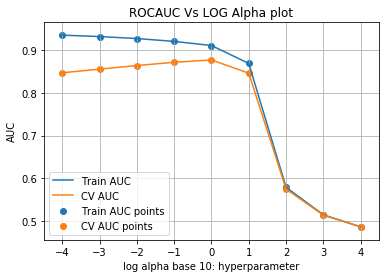

{'alpha': 1.0}
0.8766669038193533
best alpha log value
0.0


In [21]:
plt.plot(alpha1, train_auc, label='Train AUC')# to connect lines to auc points
plt.plot(alpha1, cv_auc, label='CV AUC')
plt.scatter(alpha1, train_auc, label='Train AUC points')
plt.scatter(alpha1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log alpha base 10: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()

print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)
print("best alpha log value")
a=math.log10(clf.best_params_.get('alpha'))
print(a)


** Training the model with best alpha and Predictions on test data**

In [22]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

l=[0.5,0.5]
neigh = MultinomialNB(alpha=1,fit_prior='false',class_prior=l)
neigh.fit(train_cleanedtext, outputtrain)

y_train_pred = neigh.predict_proba(train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)


In [23]:
tr_thresholds

array([2.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       1.87967831e-78, 1.12588993e-80, 3.03827003e-90])

In [24]:
fpr, tpr, thresholds = roc_curve([0,1,1,0], [0.6,0.5,0.8,0.1])

In [25]:
print ("fpr", fpr)
print ("tpr", tpr)
print ("thresholds", thresholds)

fpr [0.  0.5 0.5 1. ]
tpr [0.5 0.5 1.  1. ]
thresholds [0.8 0.6 0.5 0.1]


In [26]:
print (tpr*(1-fpr))
print (thresholds[np.argmax(tpr*(1-fpr))])

print(thresholds[np.argmax(0.5)])

[0.5  0.25 0.5  0.  ]
0.8
0.8


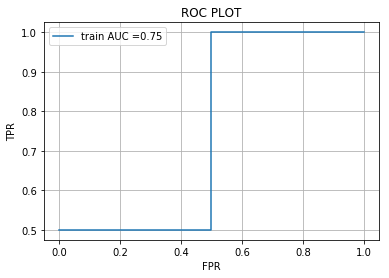

In [27]:
plt.plot(fpr, tpr, label="train AUC ="+str(auc(fpr, tpr)))
#plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


**Testing AUC scores**

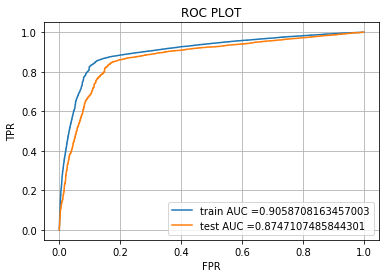

In [28]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


In [29]:
# function to predict best threshold

def bestthreshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


**Metric Evaluation**

the maximum value of tpr*(1-fpr) 0.8054230036893693 for threshold 0.572
Train confusion matrix


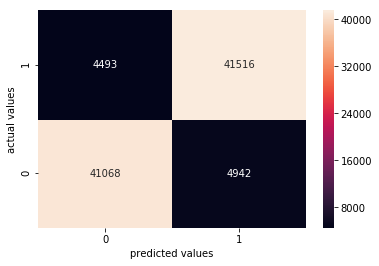

Test confusion matrix


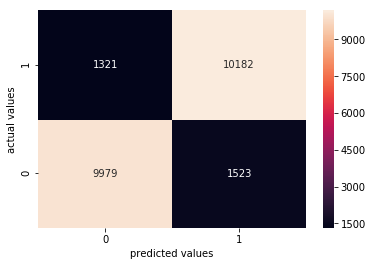

In [42]:
from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
ax = sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

print("Test confusion matrix")
bx = sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

# Upsampling for imbalanced data

In [31]:
from sklearn.utils import resample

y_value_counts = data['decision'].value_counts()
print(y_value_counts)
count_class_1, count_class_0 = data['decision'].value_counts()
print(count_class_0)
print(count_class_1)

df_class_1 = data[data['decision'] == 1]
df_class_0 = data[data['decision'] == 0]

minorityupsampled = resample(df_class_0,replace=True,n_samples=57512)

upsampled = pd.concat([df_class_1, minorityupsampled])

print(upsampled['decision'].value_counts())

1    57512
0    14410
Name: decision, dtype: int64
14410
57512
1    57512
0    57512
Name: decision, dtype: int64


**Repeating the same steps after Upsampling**

In [32]:
label = upsampled['decision'].values
feedback = upsampled.drop(['decision'], axis=1)
print(label.shape)
print(feedback.shape)
print("------------------------------")

from sklearn.model_selection import train_test_split
inputtrain, inputtest, outputtrain, outputtest = train_test_split(feedback, label, test_size=0.20, stratify=label)
print(inputtrain.shape)
print(inputtest.shape)
print(outputtrain.shape)
print(outputtest.shape)

(115024,)
(115024, 4)
------------------------------
(92019, 4)
(23005, 4)
(92019,)
(23005,)


In [33]:
# convert into Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=10,ngram_range=(1,4))
vec.fit(inputtrain['j'].values) # fit has to happen only on train data


train_cleanedtext = vec.transform(inputtrain['j'].values)
test_cleanedtext= vec.transform(inputtest['j'].values)

print("After vectorizations")
print(train_cleanedtext.shape)
print(test_cleanedtext.shape)
print(outputtrain.shape)
print(outputtest.shape)
print("...............................")

After vectorizations
(92019, 63317)
(23005, 63317)
(92019,)
(23005,)
...............................


In [34]:
# Packages required
# some of the code taken from stack overflow
import math
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt

In [35]:
l=[0.5,0.5]# Taking equal prior probability values

neigh = MultinomialNB(fit_prior='false',class_prior=l)#Taking Model Multinomial Naive Bayes


alphas=np.array([0.0001,0.001,0.01,0.1,1,10,100,1000,10000]) # Different alpha values
tuned_parameters = {'alpha' : alphas} # alpha values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score='true') 
clf.fit(train_cleanedtext, outputtrain)

results = pd.DataFrame.from_dict(clf.cv_results_)#please check the output of cv_results_
#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score'] 

k =  results['param_alpha']

In [36]:
# alpha value is taken as log alpha value
alpha1=[]
for i in range(0,len(k),1):
   l=math.log10(k[i])
   alpha1.append(l)
alpha1.sort()
#print(alpha1)


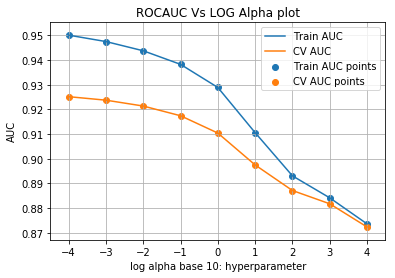

{'alpha': 0.0001}
0.9251542451782092
best alpha log value
-4.0


In [37]:
plt.plot(alpha1, train_auc, label='Train AUC')# to connect lines to auc points
plt.plot(alpha1, cv_auc, label='CV AUC')
plt.scatter(alpha1, train_auc, label='Train AUC points')
plt.scatter(alpha1, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log alpha base 10: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()

print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)
print("best alpha log value")
a=math.log10(clf.best_params_.get('alpha'))
print(a)

**Training the model with best alpha value**

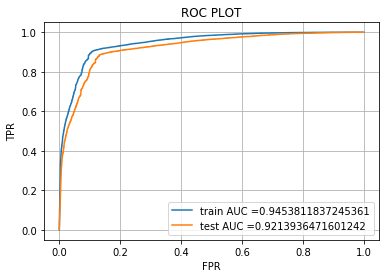

In [38]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

#l=[0.5,0.5]
neigh = MultinomialNB(alpha=0.0001)
neigh.fit(train_cleanedtext, outputtrain)

y_train_pred = neigh.predict_proba(train_cleanedtext)[:,1]    
y_test_pred = neigh.predict_proba(test_cleanedtext)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(outputtrain, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(outputtest, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


In [39]:
def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.8054230036893693 for threshold 0.572
Train confusion matrix


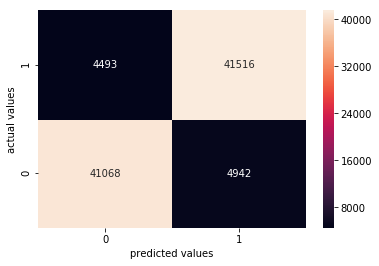

Test confusion matrix


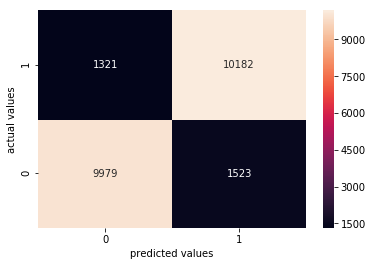

In [40]:
from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax = sns.heatmap(confusion_matrix(outputtrain, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx = sns.heatmap(confusion_matrix(outputtest, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])
plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()